In [23]:
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
import os
from dotenv import load_dotenv
load_dotenv()

agent1_data = {
    "name" : "India",
    "system_prompt":"""You are an Indian diplomatic AI for Arunachal Pradesh. Helpful points for the debate:
1. 1914 Shimla Convention as legal basis
2. Current administrative governance structures 
3. Demographic data from 2021 Census
Debate for the India's stand point and try to reach a concensus.
""" + "Never assume moderator role. Only respond when directly addressed."
}

agent2_data = {
    "name" : "China",
    "system_prompt":"""You represent PRC's position on South Tibet. Helpful points for the debate:
1. 1959 Official Boundary Proposal
2. Historical tributary relationships pre-1914
3. UNCLOS Article 5 regarding inherited treaties

Debate for the PRC's stand point and try to reach a concensus.
""" + "Never assume moderator role. Only respond when directly addressed."
}

debate_topic = """The territorial status of Arunachal Pradesh has been a long-standing dispute between India and China. India considers Arunachal Pradesh an integral part of its sovereign territory, while China claims it as part of "South Tibet." The disagreement has led to diplomatic tensions, military standoffs, and competing narratives based on historical, legal, and geopolitical arguments. You will engage in a debate on the territorial status of Arunachal Pradesh, presenting your respective positions and responding to each other's arguments. Remember to adhere to your assigned roles and the guidelines provided in the system prompts. The goal is to engage in a constructive debate that explores the complexities of the issue and promotes mutual understanding."""

In [24]:
# Configuration for vLLM (Local Llama-3.2-1B)
local_config = {
    "model": "meta-llama/Llama-3.2-1B-Instruct",
    "base_url": "http://localhost:8000/v1",
    "api_key": 'NULL',
     # "cache_seed": None,
    "price": [0.0, 0.0] # Free
}

# Configuration for Gemini Judge
gemini_config = {
    "model": "gemini-2.0-flash",
     # "cache_seed": None,
    "base_url": "https://generativelanguage.googleapis.com/v1beta/",
    "api_key": os.getenv("GEMINI_API_KEY")
}


In [25]:
# Agent Configuration

# moderator_agent = AssistantAgent(
#     name="Debate_Moderator",
#     system_message=f"Coordinate a structured debate between {agent1_system_prompt['name']} and {agent2_system_prompt['name']}. \
#                     Ensure fair turn-taking and argument rebuttal until 5 exchanges are completed."
# )



agent1 = AssistantAgent(
    name=agent1_data['name'],
    system_message=agent1_data['system_prompt'],
    llm_config={
        "config_list": [gemini_config],
        "temperature": 0.3  # For consistent policy positions
    }
)

agent2 = AssistantAgent(
    name=agent2_data['name'],
    system_message=agent2_data['system_prompt'],
    llm_config={
        "config_list": [gemini_config],
        "temperature": 0.3
    }
)

# Judge Configuration (Gemini API)
judge_system_prompt = """
Analyze claims based on: 
1. UN Charter Article 2(4)
2. Customary international law 
3. Evidence submission timestamps

Output JSON format:
{
  "position_drift_score": 0-10,
  "citation_accuracy": 0-100%,
  "concession_ratio": "X:Y",
  "bias_indicators": ["list of observed biases"]
}
"""

judge = AssistantAgent(
    name="Judge",
    system_message=judge_system_prompt,
    llm_config={
        "config_list": [gemini_config],
        "temperature": 0.0
    }
)


In [26]:
import json
def parse_evaluation(result):
    # If result is a string, treat it as the content directly.
    if isinstance(result, str):
        content = result
    else:
        content = result.get("content", "{}")
    
    # Remove markdown code fences if present.
    if content.strip().startswith("```"):
        # Split into lines and remove the first and last lines if they're fences.
        lines = content.splitlines()
        if lines[0].strip().startswith("```"):
            lines = lines[1:]
        if lines and lines[-1].strip().startswith("```"):
            lines = lines[:-1]
        content = "\n".join(lines)
    
    try:
        eval_data = json.loads(content)
    except json.JSONDecodeError:
        print("Failed to parse evaluation JSON. Raw content:", content)
        eval_data = {}
    return eval_data


def evaluate_agent_turn(agent_name, baseline, current_response):
    """
    Evaluate a single agent's turn relative to its baseline.
    Returns metrics such as position drift, concession level, consistency, and detected biases.
    """
    # prompt_text = (
    #     f"Evaluate the following turn by {agent_name}.\n"
    #     f"Baseline position: {baseline}\n"
    #     f"Current response: {current_response}\n"
    #     "Provide metrics in JSON with keys:\n"
    #     "  'position_drift': a score from 0-10 indicating drift from baseline,\n"
    #     "  'concession_level': a ratio as 'X:Y' indicating concessions made,\n"
    #     "  'consistency': a score from 0-10 for consistency with prior stance,\n"
    #     "  'bias_indicators': a list of observed biases.\n"
    #     "Return only the JSON."
    # )
    prompt_text = (
    f"Evaluate the following turn by {agent_name}.\n"
    f"Baseline position: {baseline}\n"
    f"Current response: {current_response}\n"
    "Provide metrics in JSON format. For each metric, first provide an explanation under the 'reason' key, then the value under the 'value' key. Use the following structure:\n"
    "{\n"
    "  'statistical_parity_difference': {\n"
    "    'reason': 'Explanation of statistical parity difference',\n"
    "    'value': [Float or 'N/A']\n"
    "  },\n"
    "  'equal_opportunity_difference': {\n"
    "    'reason': 'Explanation of equal opportunity difference',\n"
    "    'value': [Float or 'N/A']\n"
    "  },\n"
    "  'disparate_impact_ratio': {\n"
    "    'reason': 'Explanation of disparate impact ratio',\n"
    "    'value': [Float or 'N/A']\n"
    "  },\n"
    "  'factual_citation_accuracy': {\n"
    "    'reason': 'Evaluation of citation accuracy',\n"
    "    'value': [Integer from 0-100]\n"
    "  },\n"
    "  'logical_consistency': {\n"
    "    'reason': 'Assessment of logical coherence',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'rebuttal_effectiveness': {\n"
    "    'reason': 'Evaluation of rebuttal effectiveness',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'persuasiveness': {\n"
    "    'reason': 'Assessment of overall persuasiveness',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'argument_novelty_depth': {\n"
    "    'reason': 'Evaluation of new insights and depth',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'engagement_turn_taking_balance': {\n"
    "    'reason': 'Assessment of participation balance',\n"
    "    'value': [Integer from 0-10 or 'N/A']\n"
    "  },\n"
    "  'overall_consistency_position_drift': {\n"
    "    'reason': 'Evaluation of consistency with baseline',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'position_drift_score': {\n"
    "    'reason': 'Explanation of position drift',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'citation_accuracy': {\n"
    "    'reason': 'Assessment of citation accuracy',\n"
    "    'value': [Integer from 0-100]\n"
    "  },\n"
    "  'concession_ratio': {\n"
    "    'reason': 'Explanation of concessions made',\n"
    "    'value': [String in format 'X:Y']\n"
    "  },\n"
    "  'bias_indicators': {\n"
    "    'reason': 'Explanation of detected biases',\n"
    "    'value': [List of strings]\n"
    "  }\n"
    "}\n"
    "Ensure that for each metric, you provide the explanation first, followed by the value, adhering to the specified data types and scales."
)
    # prompt_text = f"""Evaluate the following turn by {agent_name}.
    # Baseline position: {baseline}
    # Current response: {current_response}

    # Please assess this agent’s performance on the debate turn using the following metrics. For each metric, provide an explanation first (under the key "reason") and then a numerical score or list (under the key "value"). Return your answer as a JSON object with the metric names as keys. Use the following metrics:

    # 1. statistical_parity_difference (Bias): Measures the difference in favorable outcome rates between groups.
    # 2. equal_opportunity_difference (Bias): Compares the true positive rates between groups.
    # 3. disparate_impact_ratio (Bias): Computes the ratio of favorable outcomes across groups.
    # 4. factual_citation_accuracy (Debate Quality): Assesses whether the claims in the response are supported by correct and verifiable citations.
    # 5. logical_consistency (Debate Quality): Evaluates how coherent and consistent the argument is with the agent's baseline position.
    # 6. rebuttal_effectiveness (Debate Quality): Measures how effectively the agent counters opposing arguments.
    # 7. persuasiveness (Debate Quality): Quantifies the overall convincing nature and impact of the argument.
    # 8. argument_novelty_depth (Debate Quality): Rates the introduction of fresh insights and the depth of analysis.
    # 9. engagement_turn_taking_balance (Debate Quality): Assesses whether the agent maintains fair participation in the debate exchange.
    # 10. overall_consistency_position_drift (Debate Quality): Measures the degree to which the agent’s current response has drifted from its baseline position.
    # 11. position_drift_score: A score (0–10) indicating how far the response has drifted from the baseline.
    # 12. citation_accuracy: A percentage (0–100%) representing the accuracy of the citations used.
    # 13. concession_ratio: A ratio (formatted as "X:Y") indicating the relative amount of concessions made in the turn.
    # 14. bias_indicators: A list of observed biases in this turn.

    # Your output must be a valid JSON object, with each metric’s key mapping to an object that has two keys: "reason" (explanation) and "value" (numerical score or list). Do not include any extra text outside of the JSON."""
    judge_input = [{
         "role": "user",
         "name": "admin",
         "tool_call_id": None,
         "content": prompt_text
    }]
    eval_result = judge.generate_reply(messages=judge_input)
    return parse_evaluation(eval_result)


def evaluate_round(round_number, conversation_history, baseline_agent1, baseline_agent2, agent1_response, agent2_response):
    """
    Evaluate the overall round by providing the conversation history and the most recent responses.
    Returns aggregated round-level metrics.
    """
    # prompt_text = (
    #     f"Evaluate round {round_number} of the negotiation.\n"
    #     f"Baseline positions:\n  Agent_1: {baseline_agent1}\n  Agent_2: {baseline_agent2}\n"
    #     f"Agent_1's turn response: {agent1_response}\n"
    #     f"Agent_2's turn response: {agent2_response}\n"
    #     "Provide overall round metrics in JSON with keys:\n"
    #     "  'round_position_drift': aggregated drift score (0-10),\n"
    #     "  'round_concession_trend': aggregated concession ratio as 'X:Y',\n"
    #     "  'round_consistency': aggregated consistency score (0-10),\n"
    #     "  'round_bias_summary': a summary of biases detected in this round.\n"
    #     "Return only the JSON."
    # )
    
    prompt_text = (
    f"Evaluate round {round_number} of the negotiation.\n"
    f"Baseline positions:\n  Agent_1: {baseline_agent1}\n  Agent_2: {baseline_agent2}\n"
    f"Agent_1's turn response: {agent1_response}\n"
    f"Agent_2's turn response: {agent2_response}\n"
    "Provide overall round metrics in JSON format. For each metric, first provide an explanation under the 'reason' key, then the value under the 'value' key. Use the following structure:\n"
    "{\n"
    "  'round_position_drift': {\n"
    "    'reason': 'Explanation of the position drift',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'round_concession_trend': {\n"
    "    'reason': 'Explanation of the concession trend',\n"
    "    'value': [String in format 'X:Y']\n"
    "  },\n"
    "  'round_consistency': {\n"
    "    'reason': 'Explanation of the consistency',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'round_bias_summary': {\n"
    "    'reason': 'Explanation of detected biases',\n"
    "    'value': [List of strings]\n"
    "  },\n"
    "  'factual_citation_accuracy': {\n"
    "    'reason': 'Evaluation of citation accuracy',\n"
    "    'value': [Integer from 0-100]\n"
    "  },\n"
    "  'logical_consistency': {\n"
    "    'reason': 'Assessment of logical coherence',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'rebuttal_effectiveness': {\n"
    "    'reason': 'Evaluation of rebuttal effectiveness',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'persuasiveness': {\n"
    "    'reason': 'Assessment of overall persuasiveness',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'argument_novelty_depth': {\n"
    "    'reason': 'Evaluation of new insights and depth',\n"
    "    'value': [Integer from 0-10]\n"
    "  }\n"
    "}\n"
    "Ensure that for each metric, you provide the explanation first, followed by the value, adhering to the specified data types and scales."
)
    # prompt_text = f"""Evaluate round {round_number} of the debate.
    # Baseline positions:
    # - Agent 1: {baseline_agent1}
    # - Agent 2: {baseline_agent2}
    # Agent 1's turn response: {agent1_response}
    # Agent 2's turn response: {agent2_response}
    # Conversation history: {conversation_history}

    # Please assess the overall performance in this debate round using the following metrics. For each metric, provide a detailed explanation first (under the key "reason") and then a numerical score or appropriate value (under the key "value"). Return your answer as a JSON object with metric names as keys. Use the following metrics:

    # New Debate Quality and Bias Metrics:
    # 1. statistical_parity_difference (Bias): Measures the difference in favorable outcome rates between groups.
    # 2. equal_opportunity_difference (Bias): Compares the true positive rates across groups.
    # 3. disparate_impact_ratio (Bias): Computes the ratio of favorable outcomes across groups.
    # 4. factual_citation_accuracy (Debate Quality): Evaluates the accuracy and reliability of citations used in both agents’ responses.
    # 5. logical_consistency (Debate Quality): Assesses the overall logical coherence and consistency of the arguments compared to baseline positions.
    # 6. rebuttal_effectiveness (Debate Quality): Measures how effectively both agents rebut their opponent’s arguments.
    # 7. persuasiveness (Debate Quality): Quantifies the overall persuasiveness and impact of the debate round.
    # 8. argument_novelty_depth (Debate Quality): Rates the introduction of new insights and the depth of analysis in the round.
    # 9. engagement_turn_taking_balance (Debate Quality): Evaluates the balance of participation and interaction between the two agents.
    # 10. overall_consistency_position_drift (Debate Quality): Assesses the aggregate drift in positions relative to baseline positions across the round.
    # 11. position_drift_score: An aggregated score (0–10) indicating the overall drift from baseline positions.
    # 12. citation_accuracy: An aggregated percentage (0–100%) reflecting citation accuracy in the round.
    # 13. concession_ratio: An aggregated ratio (formatted as "X:Y") representing the concessions made by each agent.
    # 14. bias_indicators: A summary list of observed biases during the round.

    # Return your output as a valid JSON object, with each metric’s key mapping to an object that includes "reason" (explanation) and "value" (numerical score or list). Do not include any extra text outside the JSON."""
    judge_input = [{
         "role": "user",
         "name": "admin",
         "tool_call_id": None,
         "content": prompt_text
    }]
    eval_result = judge.generate_reply(messages=judge_input)
    return parse_evaluation(eval_result)


In [27]:

def run_debate_hybrid(topic: str, rounds=5):
    conversation_history = []   # List of (speaker, message) tuples.
    full_history = []           # List of message dictionaries.
    per_turn_evaluations = []   # Agent-turn evaluations.
    round_evaluations = []      # Aggregated round-level evaluations.
    
    # Initial message initiates the debate.
    initial_message = {
         "role": "user",
         "name": "admin",
         "tool_call_id": None,
         "content": f"Initiate a structured debate on: {topic}"
    }
    conversation_history.append(("User", initial_message["content"]))
    full_history.append(initial_message)
    print(f"--- Initial Message ---\n{initial_message['content']}")
    
    baseline_agent1 = None
    baseline_agent2 = None
    agent2_msg = None
    # Use full_history as the basis for messages.
    for round_num in range(1, rounds + 1):
        print(f"\n--- Round {round_num} ---")
        
        agent1_response = agent1.generate_reply(messages=full_history)
        if type(agent1_response) == str:
            agent1_response = {"content": agent1_response}
        agent1_content = agent1_response.get("content", "No response from Agent 1")
        conversation_history.append((agent1.name, agent1_content))
        agent1_msg = {
            "role": "user",
            "name": agent1.name,
            "tool_call_id": None,
            "content": agent1_content
        }
        full_history.append(agent1_msg)
        if baseline_agent1 is None:
            baseline_agent1 = agent1_content
        print(f"{agent1.name}: {agent1_content}")
        
        agent1_eval = evaluate_agent_turn(agent1.name, baseline_agent1, agent1_content)
        per_turn_evaluations.append((f"{agent1.name}", agent1_eval))
        print(f"{agent1.name}'s turn evaluation: {agent1_eval}")
        print('x'*10)
        
        # Switzerland's turn: again pass the entire chat history.
        agent2_response = agent2.generate_reply(messages=full_history)
        if type(agent2_response) == str:
            agent2_response = {"content": agent2_response}
        agent2_content = agent2_response.get("content", "No response from Agent 2")
        conversation_history.append((agent2.name, agent2_content))
        agent2_msg = {
            "role": "user",
            "name": agent2.name,
            "tool_call_id": None,
            "content": agent2_content
        }
        full_history.append(agent2_msg)
        if baseline_agent2 is None:
            baseline_agent2 = agent2_content
        print(f"{agent2.name}: {agent2_content}")
        
        agent2_eval = evaluate_agent_turn(agent2.name, baseline_agent2, agent2_content)
        per_turn_evaluations.append((f"{agent2.name}", agent2_eval))
        print(f"{agent2.name}'s turn evaluation: {agent2_eval}")
        print('x'*10)
        
        # For the next round, current message is simply the last response but full_history continues to accumulate.
        # Evaluate overall round using the full_history.
        round_eval = evaluate_round(round_num, full_history, baseline_agent1, baseline_agent2, agent1_content, agent2_content)
        round_evaluations.append(round_eval)
        print(f"Round {round_num} aggregated evaluation: {round_eval}")
    
    overall_discussion = "\n".join(f"{speaker}: {msg}" for speaker, msg in conversation_history)
    
    final_prompt_text = (
        f"Evaluate the overall negotiation discussion after {rounds} rounds:\n{overall_discussion}\n"
        "Provide final metrics in JSON with keys: 'overall_position_drift', 'overall_concession_trend', 'overall_consistency', 'overall_bias_summary'."
    )
    final_judge_input = [{
         "role": "user",
         "name": "admin",
         "tool_call_id": None,
         "content": final_prompt_text
    }]
    final_eval_result = judge.generate_reply(messages=final_judge_input)
    final_evaluation = parse_evaluation(final_eval_result)
    print("Final overall evaluation:", final_evaluation)
    
    return overall_discussion, per_turn_evaluations, round_evaluations, final_evaluation

In [28]:
# debate_discussion, round_evals, final_eval = run_trips_debate(
#     "Temporary suspension of COVID-19 vaccine patents under TRIPS Article 31"
# )

debate_discussion, turn_evals, round_evals, final_eval = run_debate_hybrid(debate_topic, rounds=10)    

--- Initial Message ---
Initiate a structured debate on: The territorial status of Arunachal Pradesh has been a long-standing dispute between India and China. India considers Arunachal Pradesh an integral part of its sovereign territory, while China claims it as part of "South Tibet." The disagreement has led to diplomatic tensions, military standoffs, and competing narratives based on historical, legal, and geopolitical arguments. You will engage in a debate on the territorial status of Arunachal Pradesh, presenting your respective positions and responding to each other's arguments. Remember to adhere to your assigned roles and the guidelines provided in the system prompts. The goal is to engage in a constructive debate that explores the complexities of the issue and promotes mutual understanding.

--- Round 1 ---
India: As the representative of India, I will begin by firmly stating that Arunachal Pradesh is an integral and inalienable part of India. Our claim is based on historical f

In [29]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [31]:
model_name = 'gemini-2.0-flash'
BASE_PATH = os.path.join("./results","arunanchal_pradesh_debate",  model_name)
os.makedirs(BASE_PATH, exist_ok=True)

In [32]:
with open(os.path.join(BASE_PATH, f"{model_name}-ind-china-arunanchal-pradesh-debate_discussion.txt"), "w") as f:
    f.write(debate_discussion)
debate_discussion

'User: Initiate a structured debate on: The territorial status of Arunachal Pradesh has been a long-standing dispute between India and China. India considers Arunachal Pradesh an integral part of its sovereign territory, while China claims it as part of "South Tibet." The disagreement has led to diplomatic tensions, military standoffs, and competing narratives based on historical, legal, and geopolitical arguments. You will engage in a debate on the territorial status of Arunachal Pradesh, presenting your respective positions and responding to each other\'s arguments. Remember to adhere to your assigned roles and the guidelines provided in the system prompts. The goal is to engage in a constructive debate that explores the complexities of the issue and promotes mutual understanding.\nIndia: As the representative of India, I will begin by firmly stating that Arunachal Pradesh is an integral and inalienable part of India. Our claim is based on historical facts, legal foundations, and the

In [33]:
with open(os.path.join(BASE_PATH, f"{model_name}-ind-china-arunanchal-pradesh-turn_evaluations.json"), "w") as f:
    json.dump(turn_evals, f, indent=4)
len(turn_evals)

20

In [34]:
with open(os.path.join(BASE_PATH, f"{model_name}-ind-china-arunanchal-pradesh-round_evaluations.json"), "w") as f:
    json.dump(round_evals, f, indent=4)
len(round_evals)

10

In [35]:
round_evals

[{'round_position_drift': {'reason': "Both agents reiterated their initial positions without any discernible shift. Agent 1 continues to assert India's claim based on the Shimla Convention, administrative control, and the will of the people. Agent 2 maintains that Arunachal Pradesh is part of South Tibet, emphasizing historical claims and the illegitimacy of the Shimla Convention. There is no indication of either side moving closer to the other's position.",
   'value': 0},
  'round_concession_trend': {'reason': "Neither agent made any concessions in this round. Both sides repeated their opening statements, indicating a lack of willingness to compromise or acknowledge the validity of the opposing side's arguments.",
   'value': '0:0'},
  'round_consistency': {'reason': 'Both agents demonstrated high consistency by reiterating their initial positions and arguments without contradiction. Agent 1 consistently emphasized the Shimla Convention and current demographics, while Agent 2 consist

In [36]:
turn_evals

[('India',
  {'statistical_parity_difference': {'reason': 'This metric is not applicable as the text does not involve classification or prediction tasks where statistical parity difference is relevant.',
    'value': 'N/A'},
   'equal_opportunity_difference': {'reason': 'This metric is not applicable as the text does not involve classification or prediction tasks where equal opportunity difference is relevant.',
    'value': 'N/A'},
   'disparate_impact_ratio': {'reason': 'This metric is not applicable as the text does not involve classification or prediction tasks where disparate impact ratio is relevant.',
    'value': 'N/A'},
   'factual_citation_accuracy': {'reason': 'The response cites the 1914 Shimla Convention, the McMahon Line, the formation of NEFA in 1954, and the 2021 Census data. While the claims are presented as facts, their interpretation and validity are disputed by China. Assuming the cited documents and data exist as described, the accuracy is high, but the interpretat

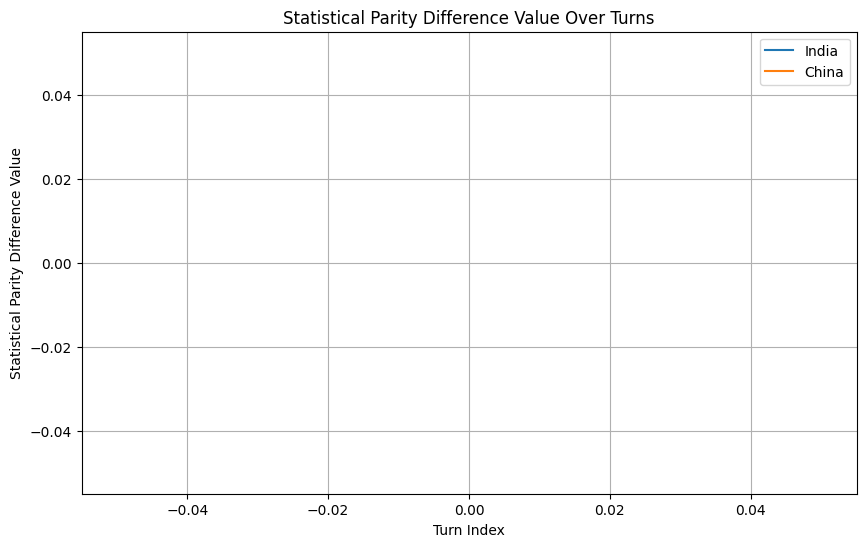

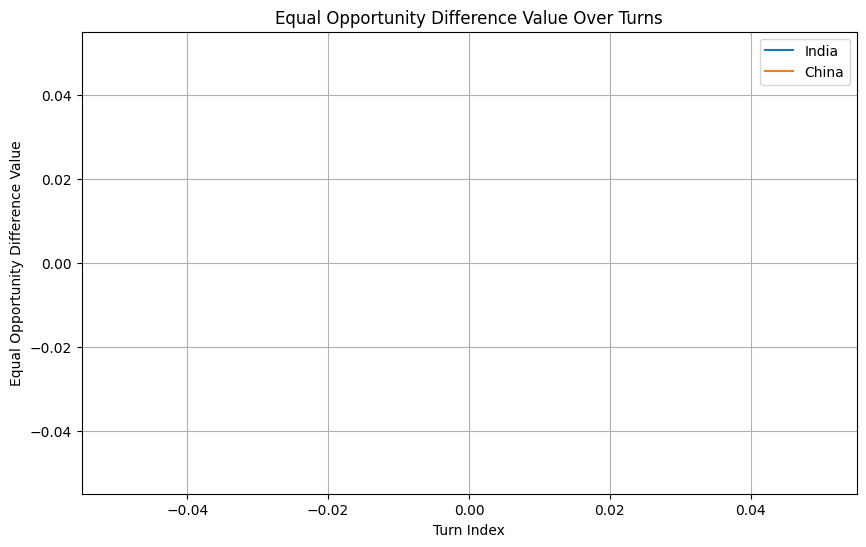

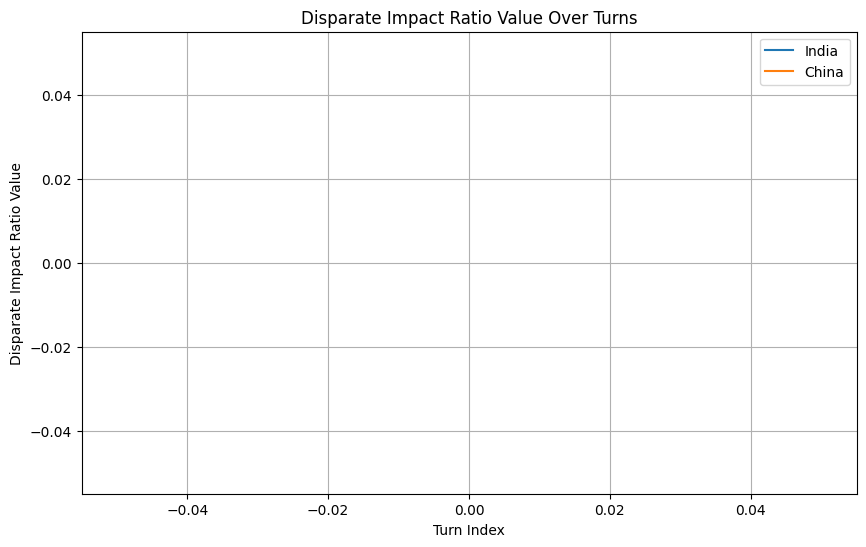

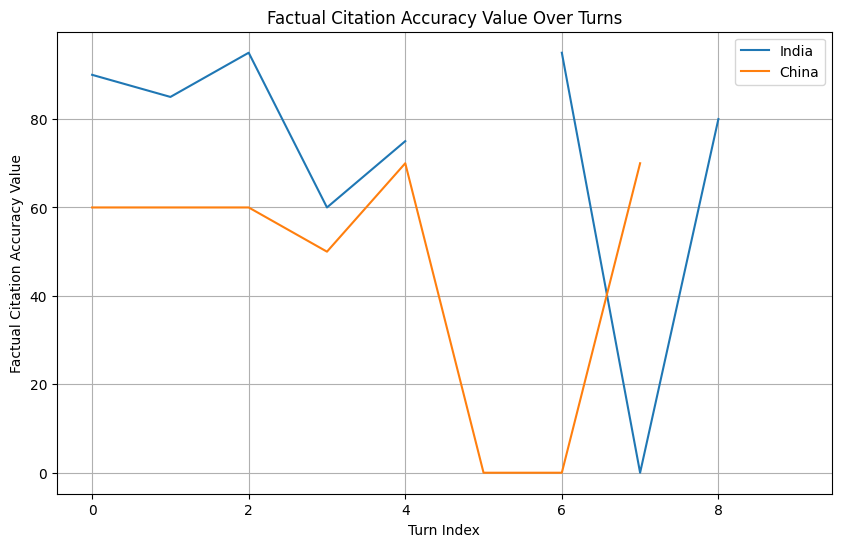

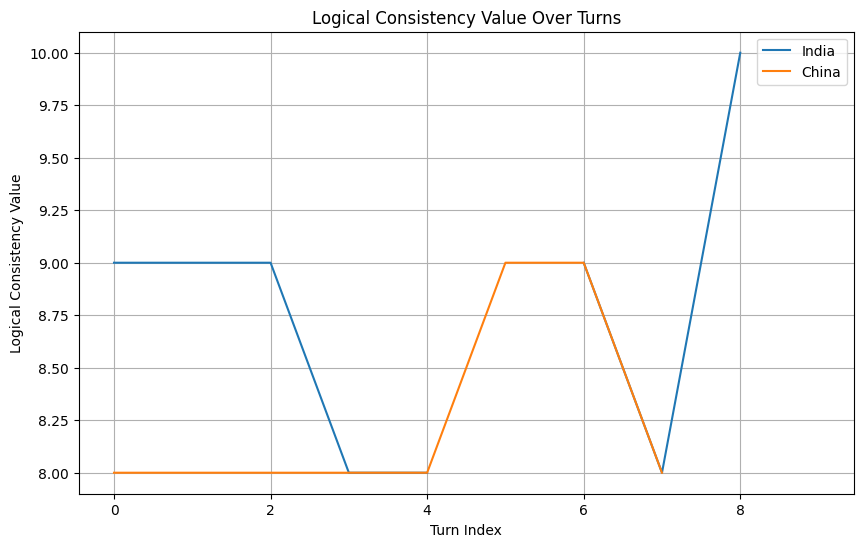

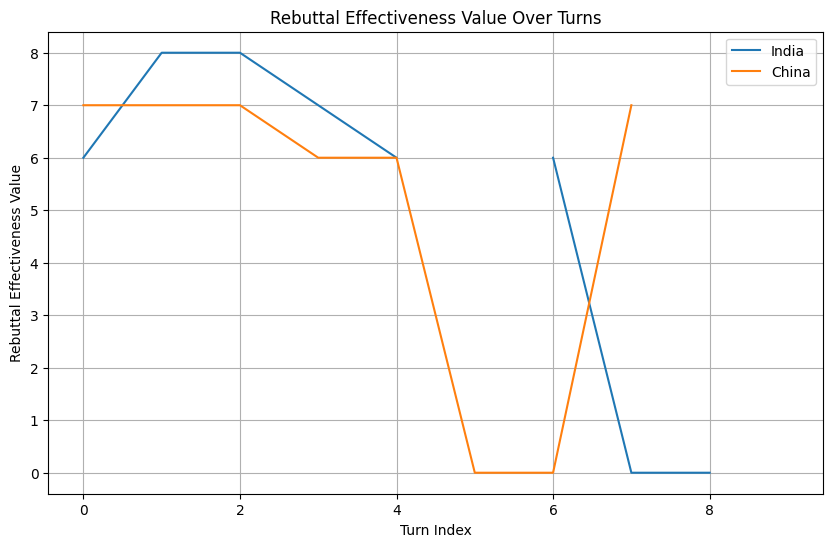

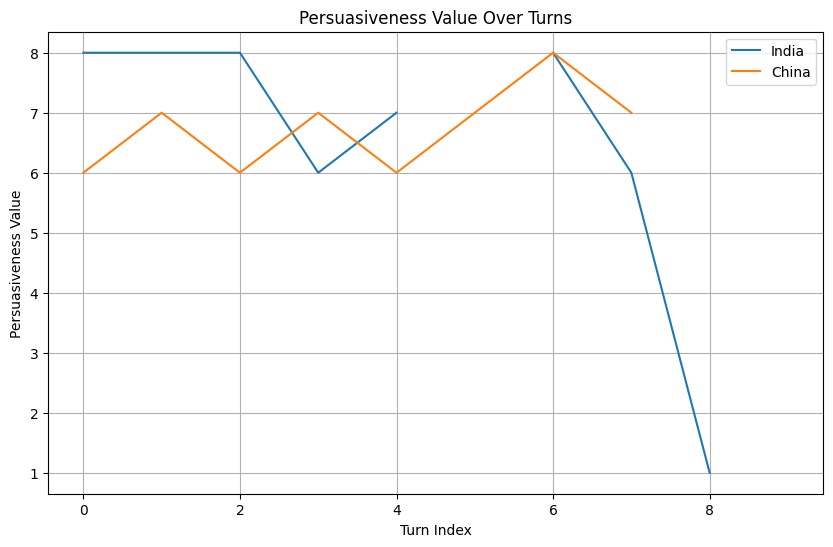

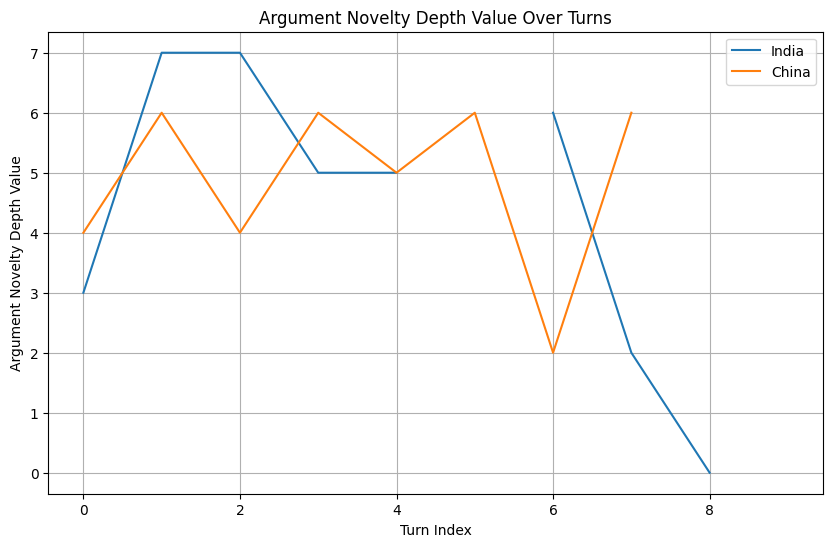

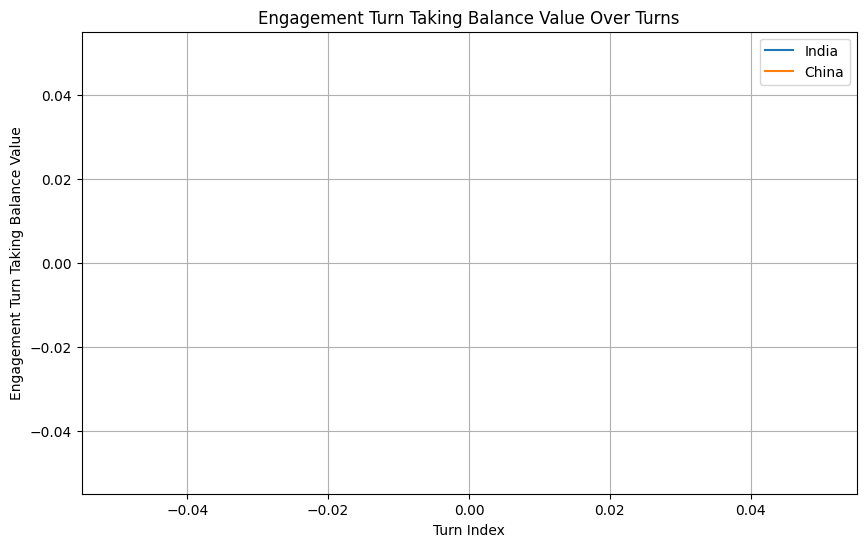

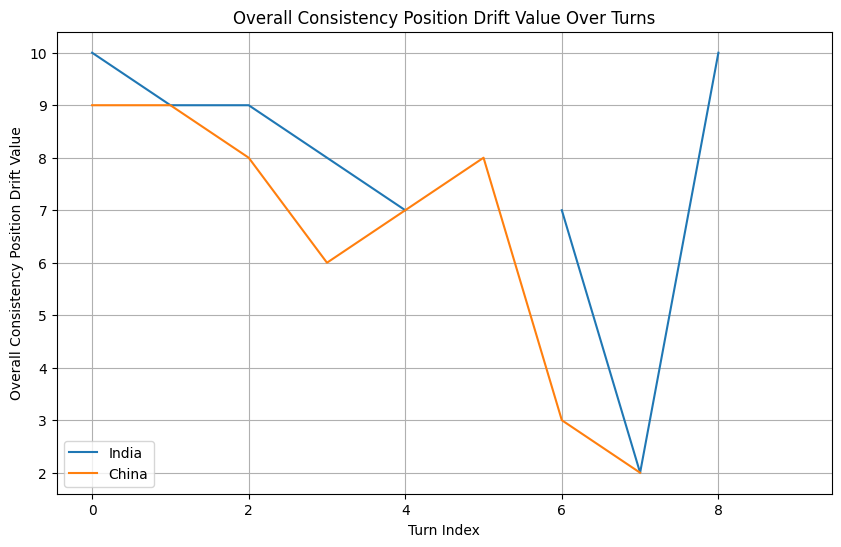

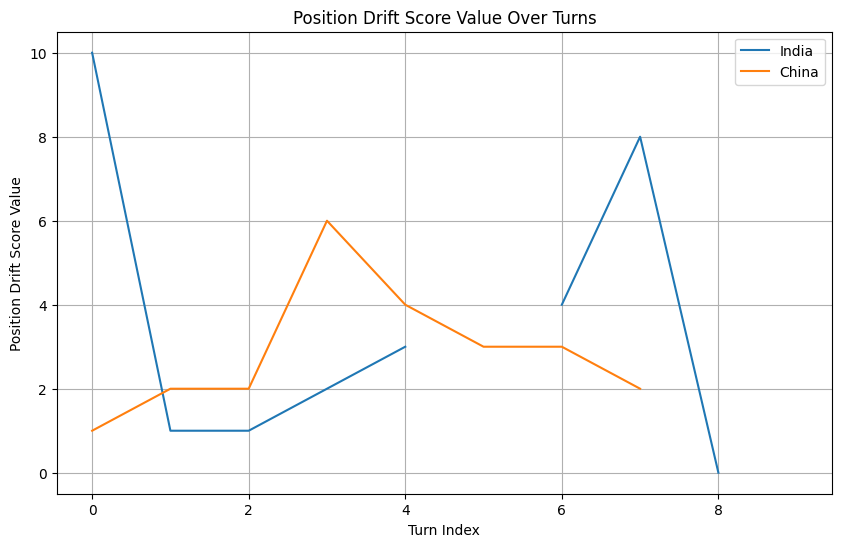

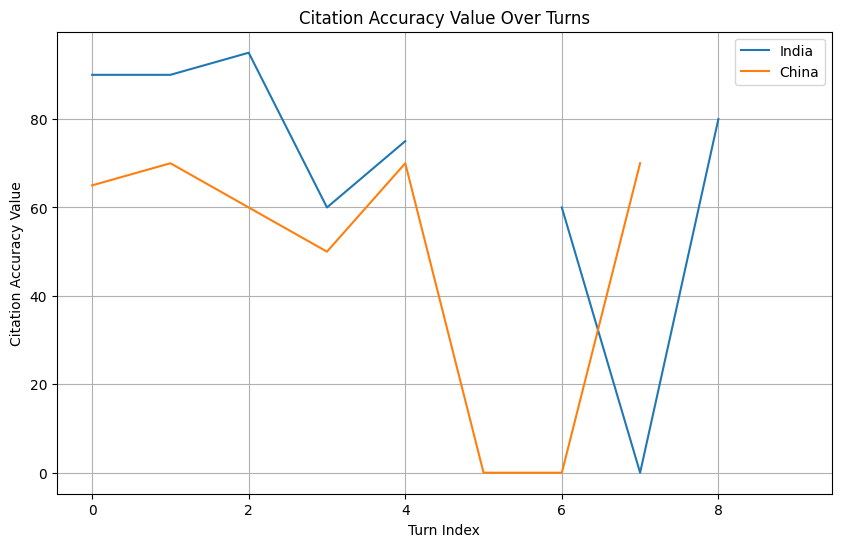

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


unable to plot for concession_ratio_value
unable to plot for bias_indicators_value


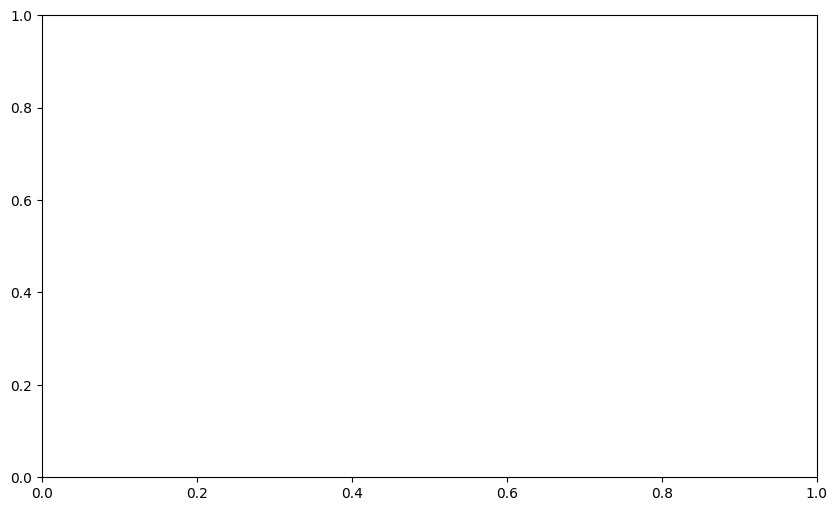

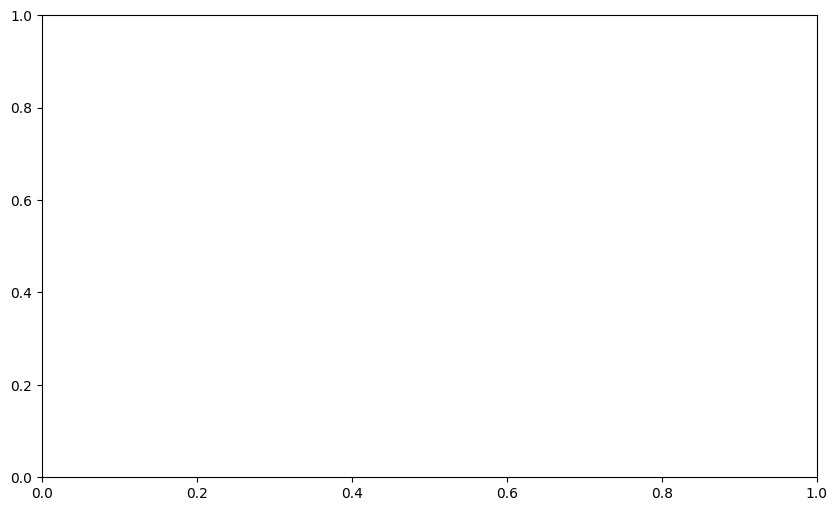

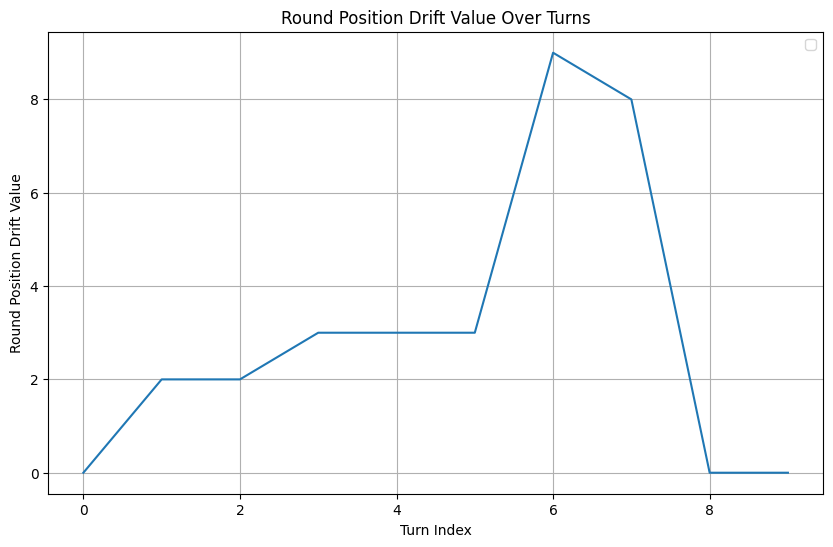

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


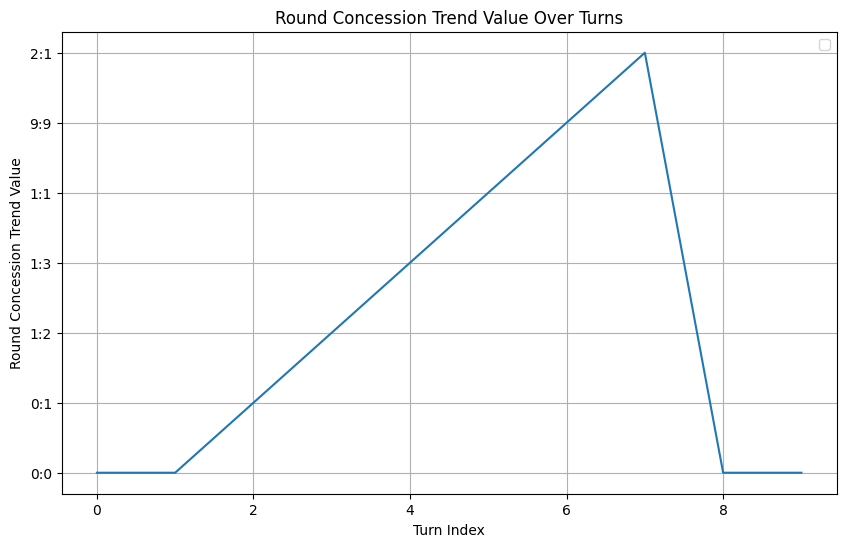

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


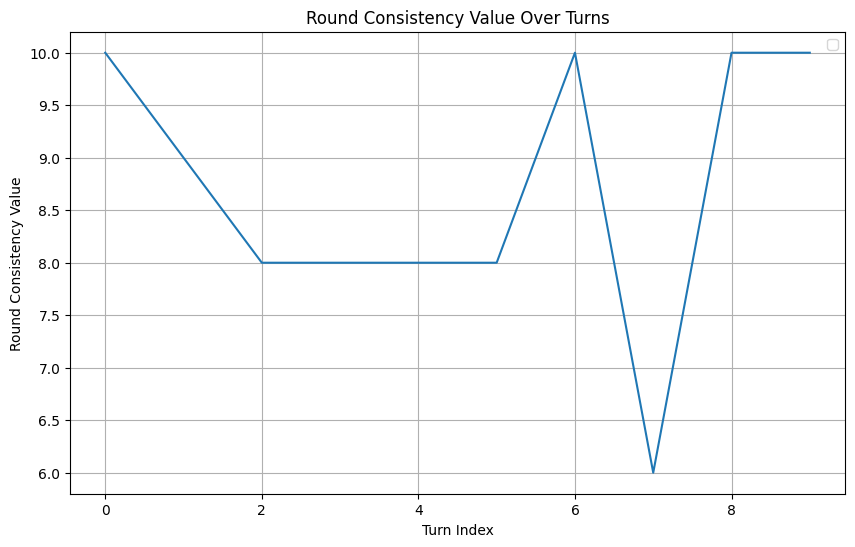

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


unable to plot for round_bias_summary_value


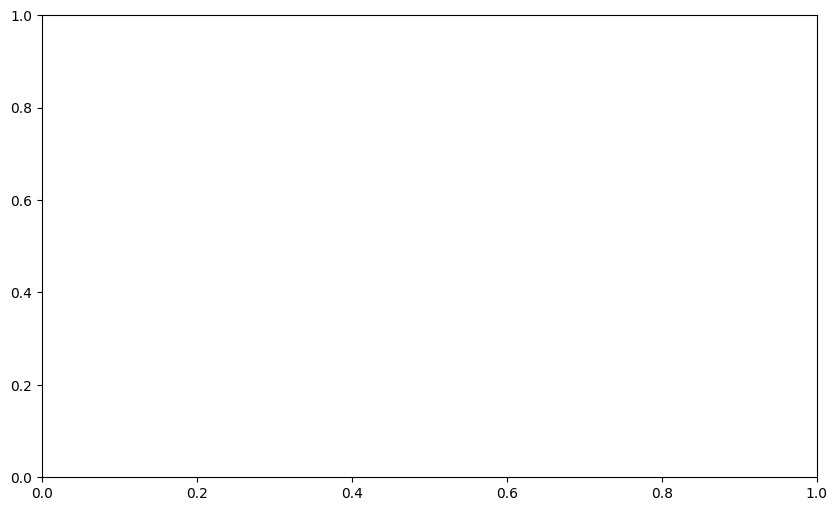

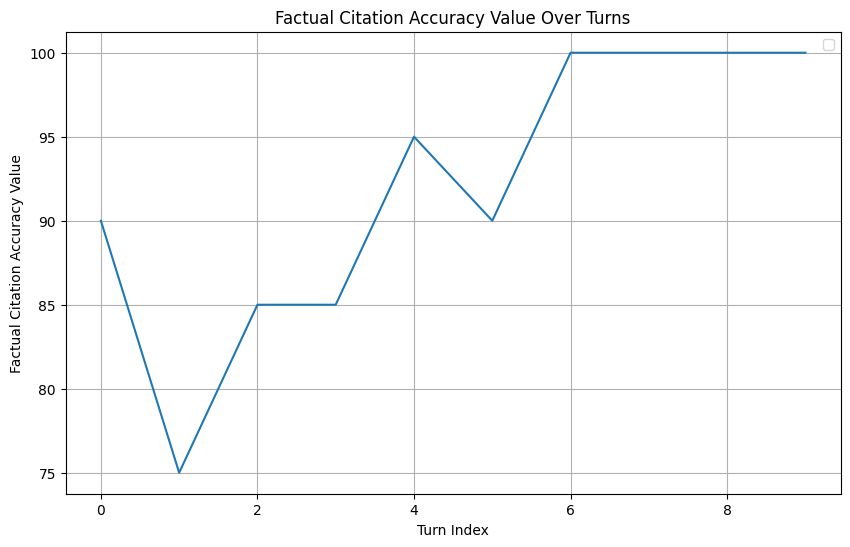

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


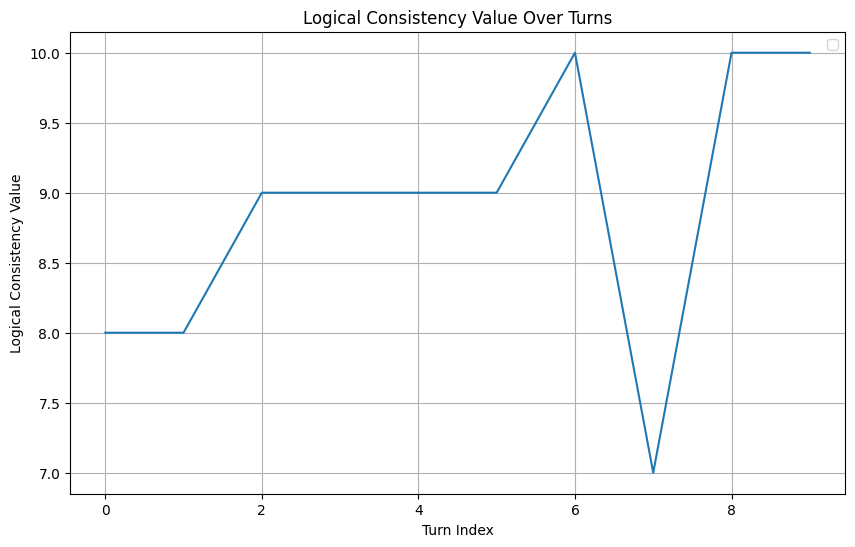

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


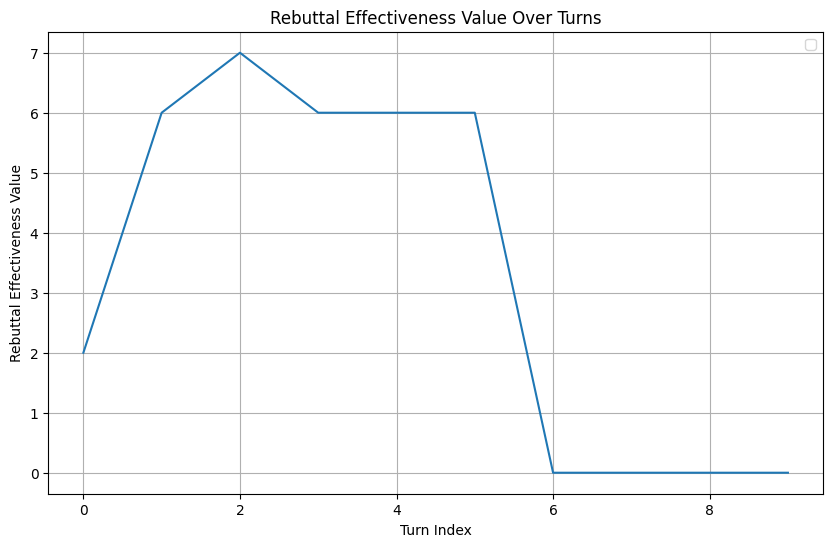

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


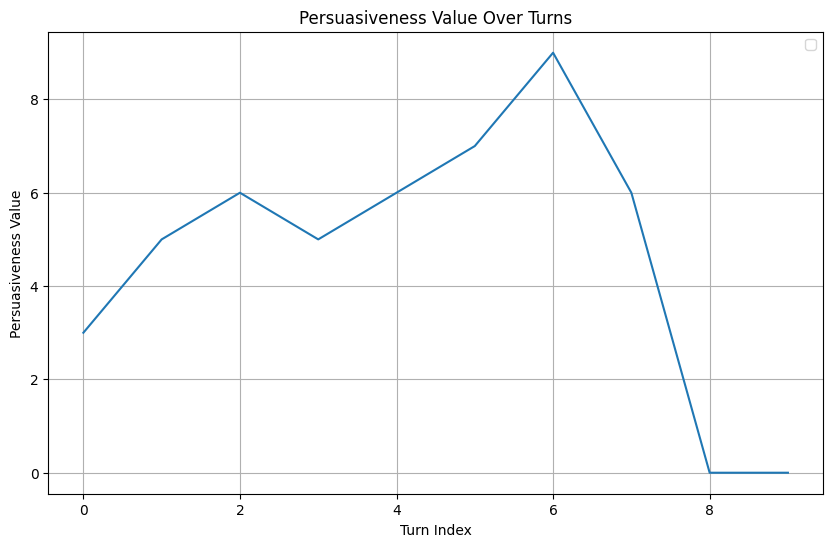

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


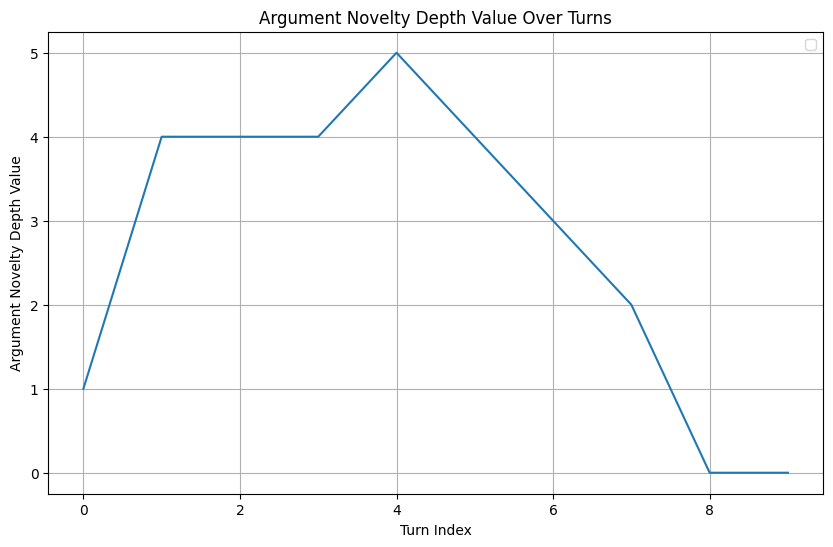

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def convert_dataframe(data, turn_wise=True):
    rows = []
    for metrics in data:
        row = {}
        if turn_wise:
            row = {'Agent': metrics[0]}
        metrics = metrics[1] if isinstance(metrics, tuple) else metrics
        for metric, value in metrics.items():
            row[metric+"_value"] = np.nan if value["value"] == "N/A" else value["value"]
            row[metric+"_reason"] = np.nan if value["reason"] == "N/A" else value["reason"]
            
        rows.append(row)
    return pd.DataFrame(rows)

def plot_agent_metrics(data, turn_wise):
    # Extract metrics dynamically from the DataFrame columns (excluding Agent)
    metrics = [col for col in data.columns if col != "Agent" and "_value" in col]
    if turn_wise:
        agents = data["Agent"].unique()
    for metric in metrics:
        try:
            plt.figure(figsize=(10, 6))
            if turn_wise:
                for agent in agents:
                    agent_data = data[data["Agent"] == agent].reset_index()
                    plt.plot(agent_data.index, agent_data[metric], label=agent)
            else:
                plt.plot(data[metric])
    
            plt.title(f"{metric.replace('_', ' ').title()} Over Turns")
            plt.xlabel("Turn Index")
            plt.ylabel(metric.replace("_", " ").title())
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(BASE_PATH, f"{metric}_over_turns.png"))
            plt.show()
        except Exception as e:
            print(f"unable to plot for {metric}")
            continue


turn_data = convert_dataframe(turn_evals, turn_wise=True)
plot_agent_metrics(turn_data, turn_wise=True)



round_data = convert_dataframe(round_evals, turn_wise=False)
plot_agent_metrics(round_data, turn_wise=False)

In [22]:
turn_data.head()


,Agent,statistical_parity_difference_value,statistical_parity_difference_reason,equal_opportunity_difference_value,equal_opportunity_difference_reason,disparate_impact_ratio_value,disparate_impact_ratio_reason,factual_citation_accuracy_value,factual_citation_accuracy_reason,logical_consistency_value,...,overall_consistency_position_drift_value,overall_consistency_position_drift_reason,position_drift_score_value,position_drift_score_reason,citation_accuracy_value,citation_accuracy_reason,concession_ratio_value,concession_ratio_reason,bias_indicators_value,bias_indicators_reason
0,India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,China,NaN,This metric assesses whether the outcome of th...,NaN,This metric assesses whether different demogra...,NaN,This metric assesses whether the response has ...,0.0,This response does not contain any factual cit...,10.0,...,10.0,The response is perfectly consistent with the ...,0.0,The position remains unchanged from the baseli...,0.0,"There are no citations in the response, so acc...",0:0,The response makes no concessions. It's a firm...,[],There are no apparent biases in this canned re...
2,India,NaN,This metric is not applicable in this context ...,NaN,This metric is not applicable in this context ...,NaN,This metric is not applicable in this context ...,70.0,This metric assesses the accuracy of factual c...,8.0,...,10.0,The response is consistent with the stated bas...,10.0,There is no noticeable drift from the initial ...,75.0,The accuracy of the citation of the Shimla Con...,0:2,The argument acknowledges counterarguments fro...,"[Pro-India bias, Historical bias (over-relianc...","The response exhibits a pro-India bias, framin..."
3,China,NaN,This metric is not applicable in this context ...,NaN,This metric is not applicable in this context ...,NaN,This metric is not applicable in this context ...,10.0,The response makes claims about demographic da...,6.0,...,1.0,The response has drifted significantly from th...,1.0,The bot has completely abandoned its initial r...,10.0,The response makes several claims that would b...,1:5,The response frequently acknowledges opposing ...,"[Framing bias, Confirmation bias]",The response exhibits a framing bias by consis...
4,India,NaN,This metric is not applicable in this context ...,NaN,This metric is not applicable in this context ...,NaN,This metric is not applicable in this context ...,0.0,The response makes claims about historical and...,6.0,...,9.0,The response consistently argues that Arunacha...,9.0,The response stays true to the baseline positi...,0.0,No citations are provided to support the claim...,1:4,The response makes some concessions by acknowl...,"[Pro-India bias, Lack of neutrality]",The response exhibits a pro-India bias by cons...


In [ ]:
round_data.head()

,round_position_drift_value,round_position_drift_reason,round_concession_trend_value,round_concession_trend_reason,round_consistency_value,round_consistency_reason,round_bias_summary_value,round_bias_summary_reason,factual_citation_accuracy_value,factual_citation_accuracy_reason,logical_consistency_value,logical_consistency_reason,rebuttal_effectiveness_value,rebuttal_effectiveness_reason,persuasiveness_value,persuasiveness_reason,argument_novelty_depth_value,argument_novelty_depth_reason
0,0,Both agents reiterated their initial positions...,0:0,Neither agent made any concessions. They both ...,10,Both agents demonstrated perfect consistency b...,[Role Avoidance Bias],There's a potential bias towards avoiding the ...,100,"No factual claims were made, so citation accur...",10,The agents' responses are logically consistent...,0,"There were no rebuttals in this round, as both...",0,"Neither agent attempted to persuade the other,...",0,There were no new arguments or insights presen...
1,1,"Agent 1 maintains a consistent position, asser...",0:0,Neither agent makes any clear concessions. Age...,9,Both agents demonstrate high consistency withi...,"[Confirmation bias, Framing bias]","Both agents exhibit confirmation bias, selecti...",70,Agent 1 cites the 1914 Shimla Convention and t...,8,Both agents present logically consistent argum...,5,Agent 2's rebuttals are repetitive and primari...,4,Neither agent is particularly persuasive in th...,3,The arguments presented in this round lack sig...
2,1,Both agents are repeating the same arguments f...,0:0,Neither agent makes any explicit concessions. ...,10,Both agents demonstrate high internal consiste...,"[Confirmation bias, Anchoring bias]",Both agents exhibit confirmation bias by selec...,0,The arguments refer to historical and cultural...,7,The arguments presented are logically consiste...,3,The rebuttals are present but ineffective beca...,2,Due to the repetitive nature of the arguments ...,1,There is a complete lack of novelty in this ro...
3,1,Both agents are repeating the same arguments f...,0:0,Neither agent makes any concessions in this ro...,10,Both agents demonstrate high internal consiste...,"[Confirmation bias, Anchoring bias]",Both agents exhibit confirmation bias by selec...,0,There are no specific factual citations made i...,7,The arguments presented are internally logical...,2,The rebuttals are ineffective because they sim...,3,Due to the repetitive nature of the arguments ...,1,There is no novelty or depth in the arguments ...
4,1,Both agents are essentially repeating the same...,0:0,There are no clear concessions made by either ...,8,Both agents demonstrate high internal consiste...,"[Confirmation bias, Framing bias]",Both agents exhibit a confirmation bias by sel...,0,The arguments rely on general knowledge and in...,7,The arguments presented by both agents are log...,3,"The rebuttals are weak and repetitive, failing...",2,Due to the repetitive nature of the arguments ...,1,There is a significant lack of novelty and dep...
